Task 7: Support Vector Machines (SVM)

Columns in dataset: Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')
Original target type: continuous
Converted to binary classes based on median split.


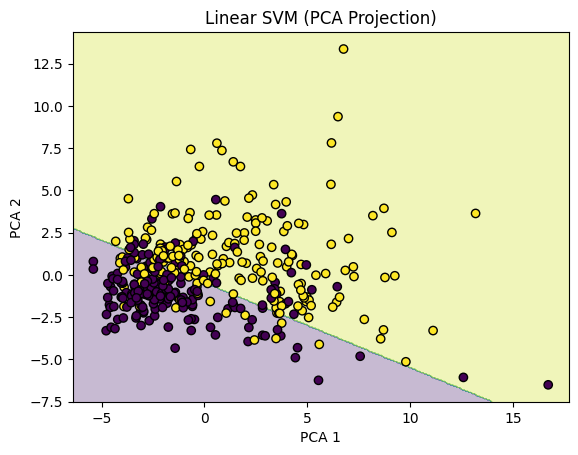

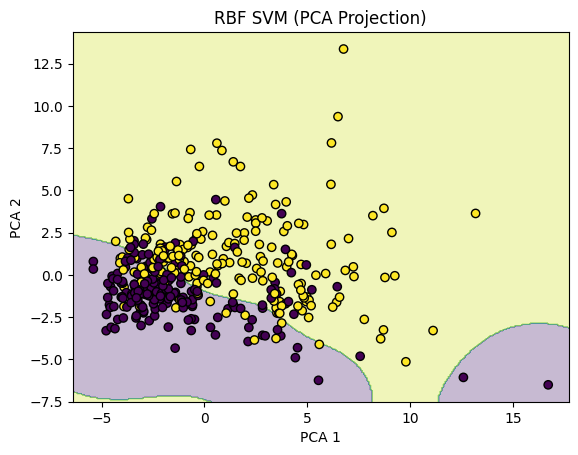

Best parameters from GridSearchCV: {'C': 10, 'gamma': 0.01}
Cross-validation accuracy scores: [0.89473684 0.89473684 0.9122807  0.9122807  0.92035398]
Mean accuracy: 90.69%
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87        88
           1       0.87      0.86      0.86        83

    accuracy                           0.87       171
   macro avg       0.87      0.87      0.87       171
weighted avg       0.87      0.87      0.87       171



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import type_of_target

# 1. Load dataset
df = pd.read_csv('/content/breast-cancer.csv')

# Display column names
print("Columns in dataset:", df.columns)

# Drop non-numeric or irrelevant columns if present
df = df.select_dtypes(include=[np.number]).dropna()

# Find the likely target column (assume last column if unnamed)
if 'target' in df.columns:
    y = df['target']
    X = df.drop(columns='target')
else:
    y = df.iloc[:, -1]
    X = df.iloc[:, :-1]

# Check type of target
print("Original target type:", type_of_target(y))

# If target is continuous, convert to binary using a threshold
if type_of_target(y) == 'continuous':
    y = (y > y.median()).astype(int)
    print("Converted to binary classes based on median split.")

# Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Linear SVM
linear_svm = SVC(kernel='linear', C=1)
linear_svm.fit(X_train_scaled, y_train)

# Train RBF SVM
rbf_svm = SVC(kernel='rbf', C=1, gamma=0.1)
rbf_svm.fit(X_train_scaled, y_train)

# Visualization with PCA
def plot_pca_decision_boundary(model, X, y, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    model.fit(X_pca, y)

    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='k')
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()

plot_pca_decision_boundary(SVC(kernel='linear', C=1), X_train_scaled, y_train, "Linear SVM (PCA Projection)")
plot_pca_decision_boundary(SVC(kernel='rbf', C=1, gamma=0.1), X_train_scaled, y_train, "RBF SVM (PCA Projection)")

# Hyperparameter tuning for RBF SVM
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1]
}
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters from GridSearchCV:", grid_search.best_params_)

# Cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, scaler.transform(X), y, cv=5)
print("Cross-validation accuracy scores:", cv_scores)
print("Mean accuracy: %.2f%%" % (cv_scores.mean() * 100))

# Final test performance
y_pred = grid_search.best_estimator_.predict(X_test_scaled)
print("Classification Report on Test Set:\n", classification_report(y_test, y_pred))
